In [1]:
%matplotlib inline
import numpy as np
import torch
torch.set_printoptions(edgeitems=2, linewidth=75)

In [2]:
# Temperature meaurements
t_c = torch.tensor([0.5, 14.0, 15.0, 28.0, 11.0,
                    8.0, 3.0, -4.0, 6.0, 13.0, 21.0])
t_u = torch.tensor([35.7, 55.9, 58.2, 81.9, 56.3, 48.9,
                    33.9, 21.8, 48.4, 60.4, 68.4])

In [3]:
def model(t_u, w_2, w_1, b):
    return w_2*t_u**2 + w_1*t_u + b

In [4]:
def loss_fn(t_p, t_c):
    squared_diffs = (t_p - t_c)**2
    return squared_diffs.mean()

In [5]:
n_samples = t_u.shape[0]
n_val = int(0.2 * n_samples)

shuffled_indices = torch.randperm(n_samples, generator=torch.Generator().manual_seed(42))

train_indices = shuffled_indices[:-n_val]
val_indices = shuffled_indices[-n_val:]

train_indices, val_indices  # <1>

(tensor([ 6,  8,  9,  2,  1, 10,  0,  7,  3]), tensor([5, 4]))

In [6]:
train_t_u = t_u[train_indices]
train_t_c = t_c[train_indices]

val_t_u = t_u[val_indices]
val_t_c = t_c[val_indices]

train_t_un = 0.1 * train_t_u
val_t_un = 0.1 * val_t_u

In [7]:
def training_loop(n_epochs, optimizer, params, train_t_u, val_t_u,
                  train_t_c, val_t_c):
    for epoch in range(1, n_epochs + 1):
        train_t_p = model(train_t_u, *params)
        train_loss = loss_fn(train_t_p, train_t_c)

        with torch.no_grad(): # <1>
            val_t_p = model(val_t_u, *params)
            val_loss = loss_fn(val_t_p, val_t_c)
            assert val_loss.requires_grad == False # <2>
            
        optimizer.zero_grad()
        train_loss.backward()
        optimizer.step()

        
        if epoch <= 3 or epoch % 500 == 0:
            print(f"Epoch {epoch}, Training loss {train_loss.item():.4f},"
                  f" Validation loss {val_loss.item():.4f}")
    return params
    

In [8]:
import torch.optim as optim

dir(optim)

['ASGD',
 'Adadelta',
 'Adagrad',
 'Adam',
 'AdamW',
 'Adamax',
 'LBFGS',
 'NAdam',
 'Optimizer',
 'RAdam',
 'RMSprop',
 'Rprop',
 'SGD',
 'SparseAdam',
 '__builtins__',
 '__cached__',
 '__doc__',
 '__file__',
 '__loader__',
 '__name__',
 '__package__',
 '__path__',
 '__spec__',
 '_functional',
 '_multi_tensor',
 'lr_scheduler',
 'swa_utils']

In [9]:
params = torch.tensor([1.0, 1.0, 0.0], requires_grad=True)
learning_rate = 1e-4
optimizer = optim.SGD([params], lr=learning_rate)

training_loop(
    n_epochs = 5000, 
    optimizer = optimizer,
    params = params,
    train_t_u = train_t_un, # <1> 
    val_t_u = val_t_un, # <1> 
    train_t_c = train_t_c,
    val_t_c = val_t_c)

Epoch 1, Training loss 700.8784, Validation loss 562.9166
Epoch 2, Training loss 400.5066, Validation loss 339.8012
Epoch 3, Training loss 231.7319, Validation loss 209.3004
Epoch 500, Training loss 11.9179, Validation loss 4.7955
Epoch 1000, Training loss 9.5623, Validation loss 3.3341
Epoch 1500, Training loss 7.9316, Validation loss 2.3322
Epoch 2000, Training loss 6.8021, Validation loss 1.6464
Epoch 2500, Training loss 6.0192, Validation loss 1.1780
Epoch 3000, Training loss 5.4761, Validation loss 0.8588
Epoch 3500, Training loss 5.0987, Validation loss 0.6419
Epoch 4000, Training loss 4.8360, Validation loss 0.4951
Epoch 4500, Training loss 4.6525, Validation loss 0.3961
Epoch 5000, Training loss 4.5239, Validation loss 0.3298


tensor([ 0.5676, -0.9301, -0.9460], requires_grad=True)

In [10]:
# Linear Model
def model_ln(t_u, w, b):
    return w * t_u + b

# Training Loop for the linear model
def training_loop_ln(n_epochs, optimizer, params, train_t_u, val_t_u,
                  train_t_c, val_t_c):
    for epoch in range(1, n_epochs + 1):
        train_t_p = model_ln(train_t_u, *params)
        train_loss = loss_fn(train_t_p, train_t_c)

        with torch.no_grad():
            val_t_p = model_ln(val_t_u, *params)
            val_loss = loss_fn(val_t_p, val_t_c)
            assert val_loss.requires_grad == False
            
        optimizer.zero_grad()
        train_loss.backward()
        optimizer.step()
        
        if epoch <= 3 or epoch % 500 == 0:
            print(f"Epoch {epoch}, Training loss {train_loss.item():.4f},"
                  f" Validation loss {val_loss.item():.4f}")
    return params


In [11]:
params_ln = torch.tensor([1.0, 0.0], requires_grad=True)
learning_rate_ln = 1e-2
optimizer_ln = optim.SGD([params_ln], lr=learning_rate_ln)

training_loop_ln(
    n_epochs = 5000, 
    optimizer = optimizer_ln,
    params = params_ln,
    train_t_u = train_t_un,
    val_t_u = val_t_un,
    train_t_c = train_t_c,
    val_t_c = val_t_c)

Epoch 1, Training loss 93.9443, Validation loss 19.2545
Epoch 2, Training loss 43.2299, Validation loss 0.7752
Epoch 3, Training loss 35.5362, Validation loss 4.8714
Epoch 500, Training loss 7.1039, Validation loss 5.2108
Epoch 1000, Training loss 3.5098, Validation loss 3.8908
Epoch 1500, Training loss 3.0399, Validation loss 3.5031
Epoch 2000, Training loss 2.9784, Validation loss 3.3746
Epoch 2500, Training loss 2.9704, Validation loss 3.3296
Epoch 3000, Training loss 2.9693, Validation loss 3.3136
Epoch 3500, Training loss 2.9692, Validation loss 3.3078
Epoch 4000, Training loss 2.9692, Validation loss 3.3057
Epoch 4500, Training loss 2.9692, Validation loss 3.3050
Epoch 5000, Training loss 2.9692, Validation loss 3.3047


tensor([  5.3904, -17.1041], requires_grad=True)

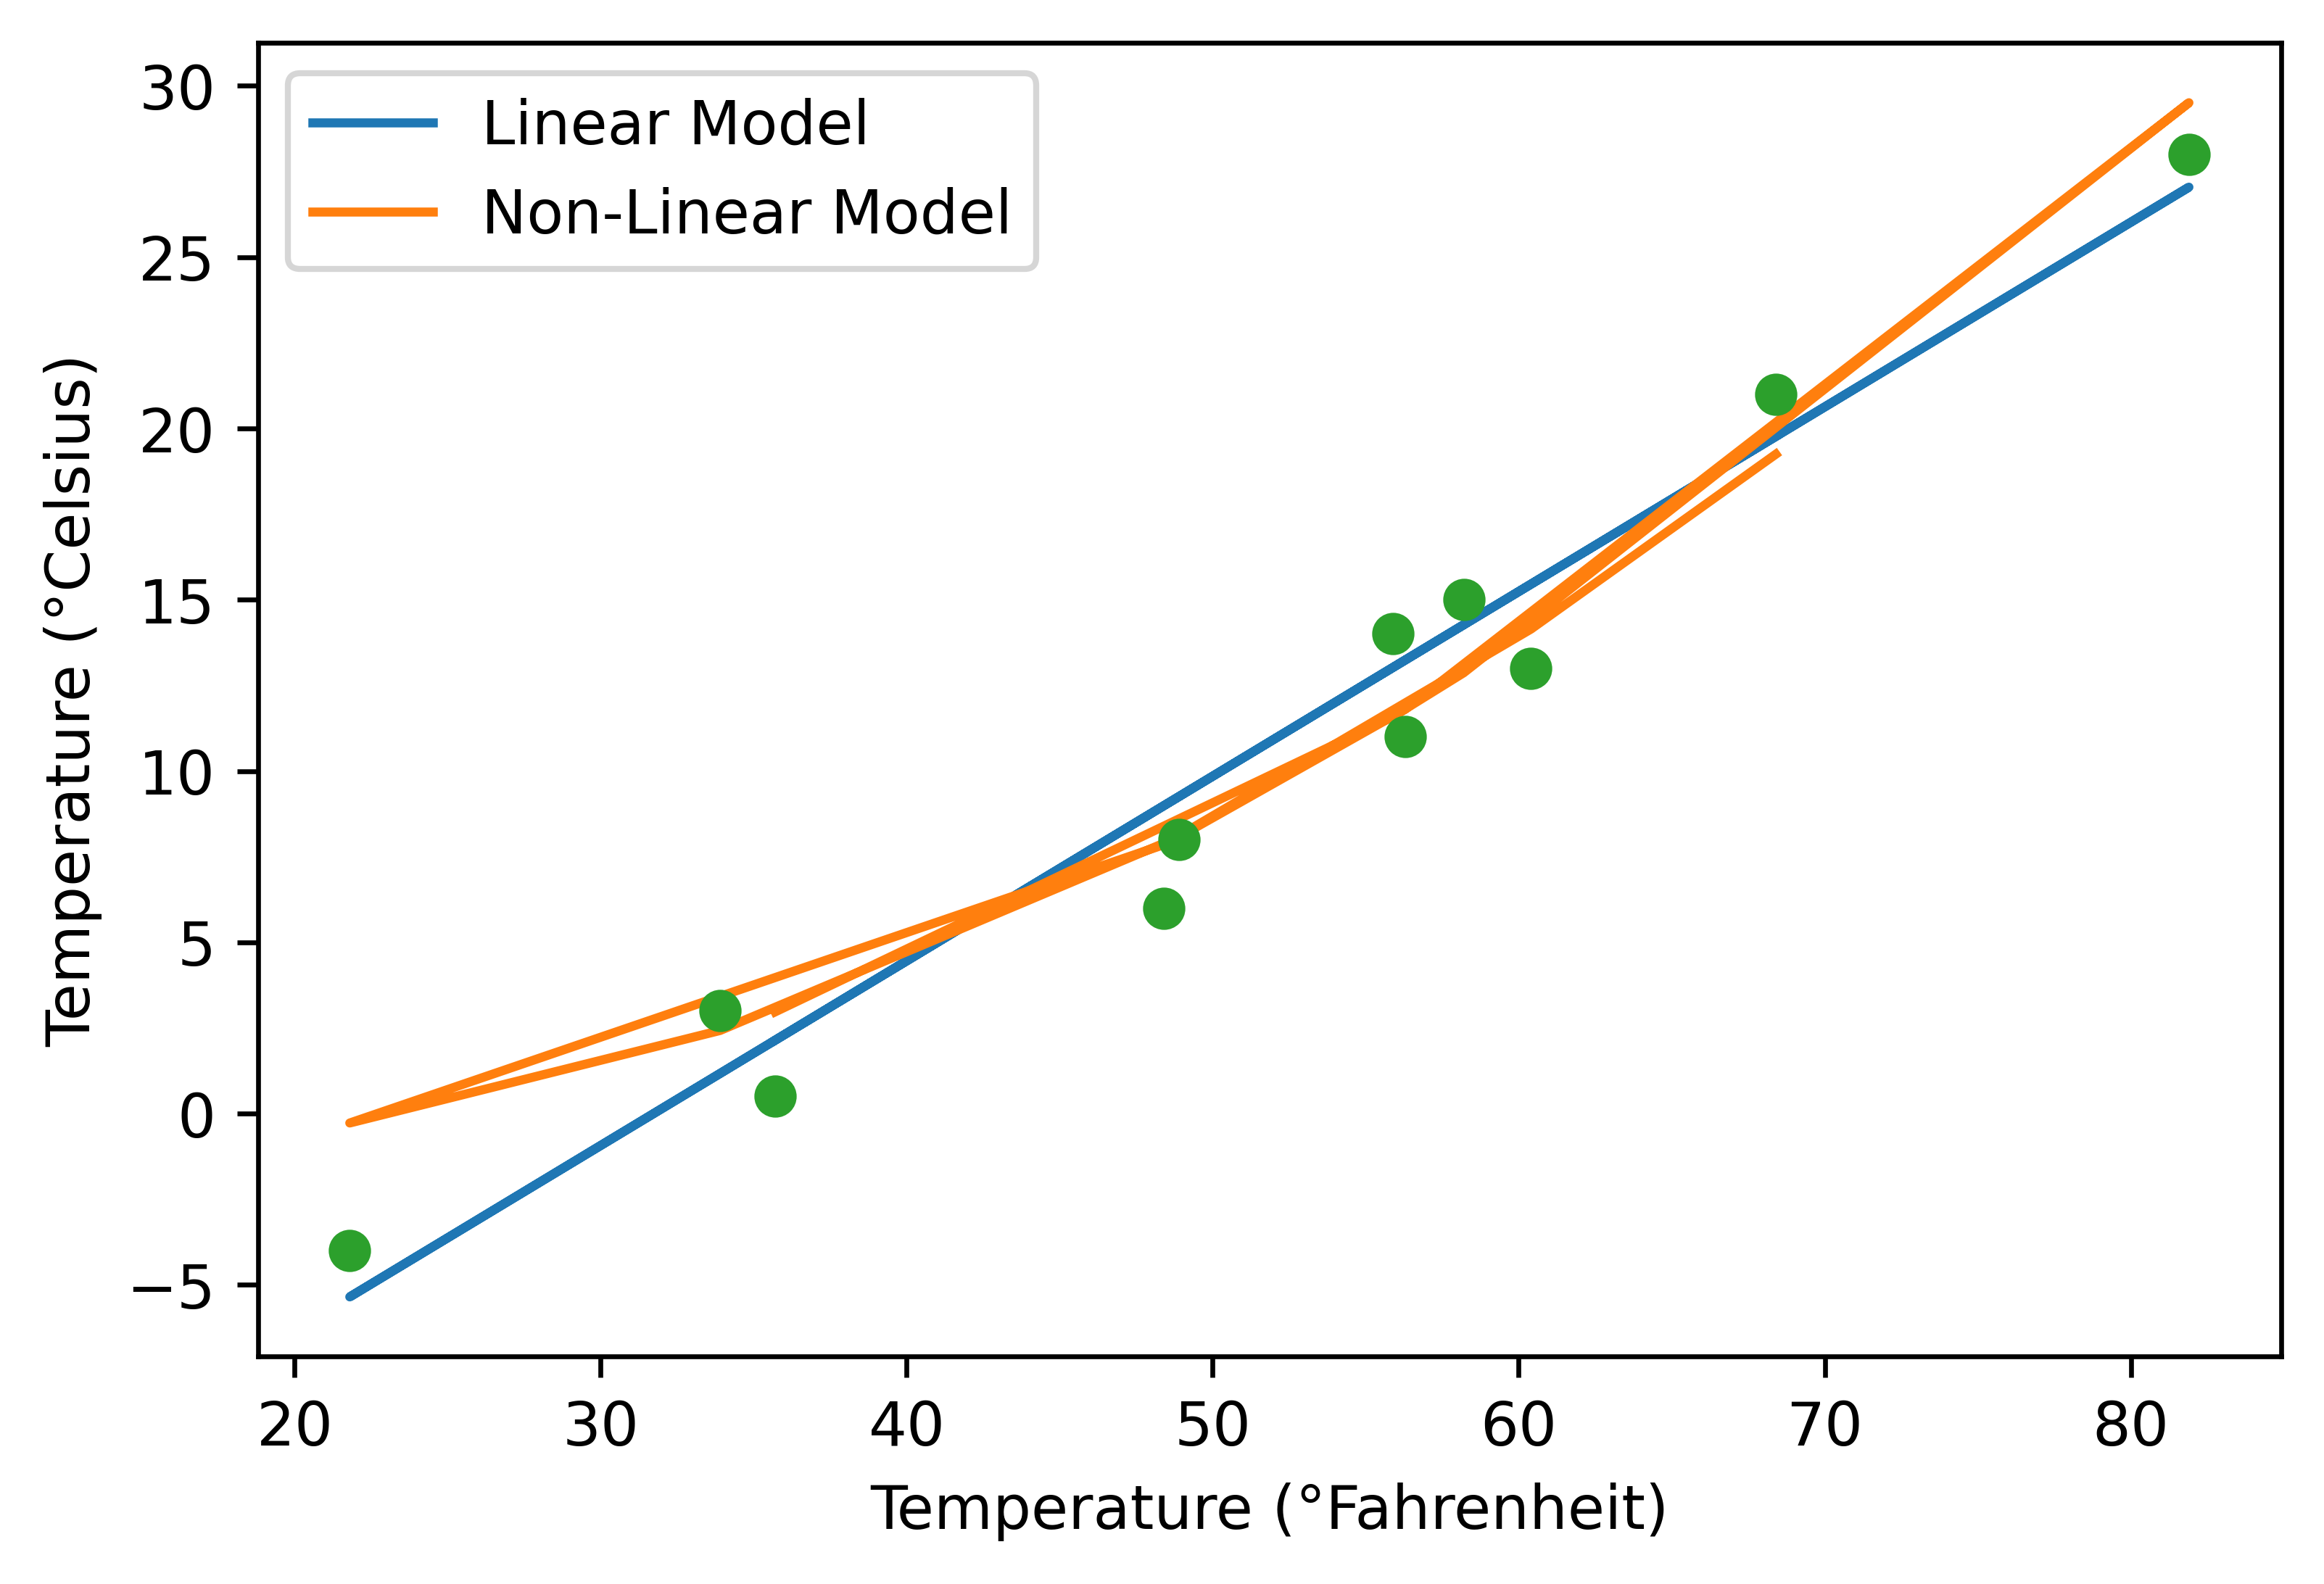

In [12]:
%matplotlib inline
import matplotlib.pyplot as plt

t_un = 0.1 * t_u
t_p_ln = model_ln(t_un, *params_ln)
t_p = model(t_un, *params)

fig = plt.figure(dpi=600)
plt.xlabel("Temperature (°Fahrenheit)")
plt.ylabel("Temperature (°Celsius)")
plt.plot(t_u.numpy(), t_p_ln.detach().numpy(), label="Linear Model")
plt.plot(t_u.numpy(), t_p.detach().numpy(), label="Non-Linear Model")
plt.plot(t_u.numpy(), t_c.numpy(), 'o')
plt.legend()
plt.savefig("temp_unknown_plot.png", format="png")